In [1]:
import numpy as np
import graphinglib as gl
import uncertainties
import uncertainties.unumpy as unp

from typing import Self

In [2]:
class Micrograph:
    def __init__(self, data: np.ndarray, index: int) -> Self:
        self.data = data
        self._index = index
        self.fft = np.fft.fftshift(np.fft.fft2(data))
        self.image_center = np.array(self.data.shape) / 2

    @classmethod
    def load(cls, filename: str) -> Self:
        return cls(gl.Heatmap(filename).image, int(filename[-5]))
    
    @property
    def data_plot(self) -> gl.Heatmap:
        return gl.Heatmap(self.data, aspect_ratio="equal", color_map="gray", show_color_bar=False)

    @property
    def fft_plot(self) -> gl.Heatmap:
        return gl.Heatmap(np.abs(self.fft), aspect_ratio="equal", vmax=1e5, color_map="gray", show_color_bar=False)

    @property
    def node_coordinates(self) -> np.ndarray:
        match self._index:
            case 1:
                return np.array([
                    [524, 844],
                    [642, 555],
                ])
            case 2:
                return np.array([
                    [512.5, 734.5],
                    [628, 477.5],
                ])
            case 3:
                return np.array([
                    [594, 747.5],
                    [648.5, 526],
                ])
            case _:
                raise ValueError("Unsupported index")

    @property
    def vectors(self) -> np.ndarray:
        return self.node_coordinates - self.image_center


    @property
    def fft_plane_distances(self) -> dict[str, uncertainties.core.Variable]:
        h, k = (uncertainties.unumpy.uarray(self.vectors[i], [3,3]) for i in range(2))
        return {
            "100" : self.vector_norm(h),
            "010" : self.vector_norm(k),
            "110" : self.vector_norm(h+k),
            "1-10" : self.vector_norm(h-k),
        }

    @property
    def gl_arrows(self) -> list[gl.Arrow, gl.Text, gl.Arrow, gl.Text]:
        n_coords = self.node_coordinates
        c = self.image_center
        return [
            gl.Arrow(c, (n_coords[0,0], n_coords[0,1]), color="yellow", width=2),
            gl.Text((n_coords[0,0]-c[0])/2+c[0]+25, (n_coords[0,1]-c[1])/2+c[1], "h", color="yellow"),
            gl.Arrow(c, (n_coords[1,0], n_coords[1,1]), color="lime", width=2),
            gl.Text((n_coords[1,0]-c[0])/2+c[0], (n_coords[1,1]-c[1])/2+c[1]-25, "k", color="lime"),
        ]
    
    @staticmethod
    def vector_norm(vector: np.ndarray) -> float:
        return (sum(vector**2))**0.5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/graphinglib/figure.py:326: UserWarning: Axes on this figure have been removed.
  warn("Axes on this figure have been removed.")


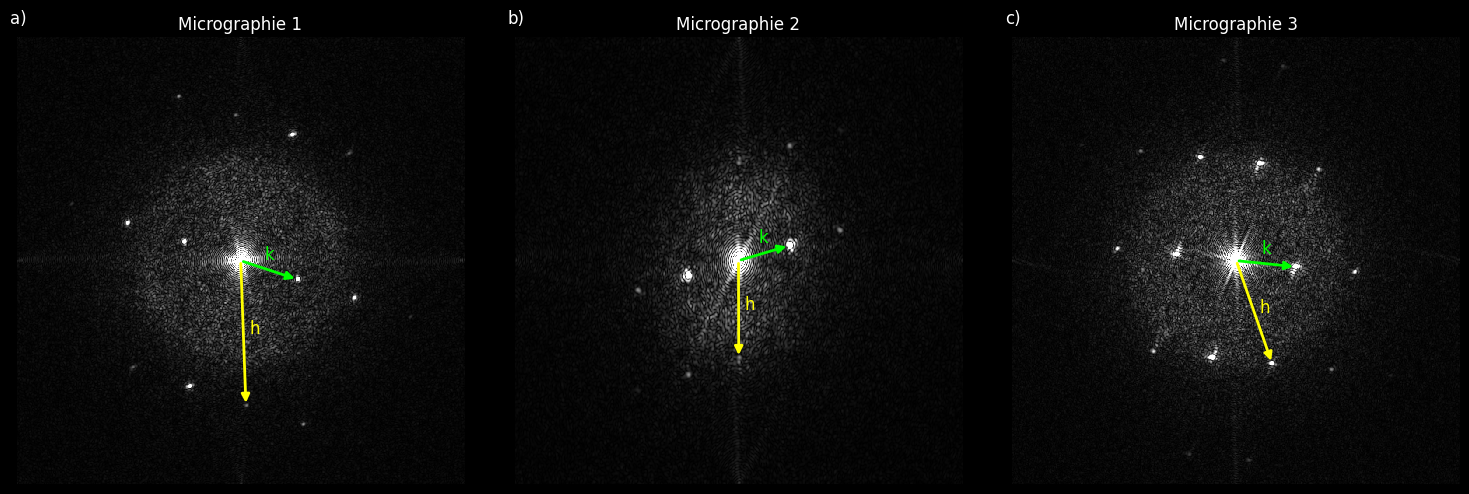

In [3]:
# %matplotlib tk
%matplotlib inline

figs = []
for i in range(1,4):
    mg = Micrograph.load(f"design/data/Micrographie_{i}.tif")
    fig = gl.Figure(size=(5, 5), figure_style="dark", title=f"Micrographie {i}", remove_axes=True)
    # fig.add_elements(mg.data_plot)
    fig.add_elements(mg.fft_plot, *mg.gl_arrows)
    figs.append(fig)
    # fig.show()

multifig = gl.MultiFigure.from_row(figs, size=(15, 5), figure_style="dark")
multifig.show()

### Base vector distances

In [4]:
im_size = 1024
px_res = 42.468     # picometers per pixel

for i in range(1,4):
    mg = Micrograph.load(f"design/data/Micrographie_{i}.tif")

    for key, value in mg.fft_plane_distances.items():
        print(f"Micrographie {i}, {key} : {im_size/(value)*px_res} pm")
    print()

Micrographie 1, 100 : 130.9+/-1.2 pm
Micrographie 1, 010 : 318+/-7 pm
Micrographie 1, 110 : 108.5+/-1.1 pm
Micrographie 1, 1-10 : 139.3+/-1.9 pm

Micrographie 2, 100 : 195.4+/-2.6 pm
Micrographie 2, 010 : 359+/-9 pm
Micrographie 2, 110 : 197+/-4 pm
Micrographie 2, 1-10 : 154.3+/-2.3 pm

Micrographie 3, 100 : 174.4+/-2.1 pm
Micrographie 3, 010 : 317+/-7 pm
Micrographie 3, 110 : 131.1+/-1.7 pm
Micrographie 3, 1-10 : 190.6+/-3.5 pm



### Coordinate-based distances

In [5]:
mg_1 = unp.uarray([
    [[np.nan,np.nan], [369.6,137.55], [499.5, 180.5], [629.5, 224.5], [np.nan,np.nan]],
    [[253.1,426.3], [382.2,469.1], [512,512], [642,554.8], [771.4,597.7]],
    [[np.nan,np.nan], [395.2,799.5], [524.4,843.5], [654.5,886.6], [np.nan,np.nan]],
], np.full((3,5,2), 3))

mg_2 = unp.uarray([
    [[np.nan,np.nan], [np.nan,np.nan], [511.5,289.7], [627.5,250.5], [np.nan,np.nan]],
    [[281.5,580.5], [386.6,545], [512,512], [628,477.7], [743.1,443.6]],
    [[np.nan,np.nan], [396.5,773.6], [512.6,734.2], [np.nan,np.nan], [np.nan,np.nan]],
], np.full((3,5,2), 3))

mg_3 = unp.uarray([
    [[np.nan,np.nan], [294,262.4], [430.4,276.5], [567.3,290.2], [700.5,303.6]],
    [[240.6,485.7], [376.7,497.9], [512,512], [648.2,526], [783.6,538.4]],
    [[323.7,720.6], [458.6,733.6], [594.1,747.5], [730.1,762], [np.nan,np.nan]],
], np.full((3,5,2), 3))

k = im_size*px_res

for i, mg in enumerate([mg_1, mg_2, mg_3]):
    print(f"\nMicrographie {i+1}")

    d_100 = k/np.array([Micrograph.vector_norm(mg[i,j]-mg[i+1,j]) for i, j in [[0,2],[0,3],[1,1],[1,2]]])
    d_010 = k/np.array([Micrograph.vector_norm(mg[i,j]-mg[i,j+1]) for i, j in [[0,2],[1,0],[1,1],[1,2],[1,3],[2,1]]])
    d_110 = k/np.array([Micrograph.vector_norm(mg[i,j]-mg[i+1,j+1]) for i, j in [[0,2],[0,3],[1,0],[1,1]]])
    d_1bar10 = k/np.array([Micrograph.vector_norm(mg[i,j]-mg[i+1,j-1]) for i, j in [[0,2],[0,3],[1,2],[1,3]]])

    for key, value in zip(["100", "010", "110", "1-10"], [d_100, d_010, d_110, d_1bar10]):
        print(f"{key} : {unp.nominal_values(value).mean():.0f} ± "
              f"{np.sqrt(unp.std_devs(value)[0]**2 + unp.nominal_values(value).std()**2):.0f} pm")


Micrographie 1
100 : 131 ± 2 pm
010 : 318 ± 10 pm
110 : 109 ± 1 pm
1-10 : 140 ± 2 pm

Micrographie 2
100 : 193 ± 5 pm
010 : 360 ± 21 pm
110 : 194 ± 4 pm
1-10 : 153 ± 3 pm

Micrographie 3
100 : 174 ± 3 pm
010 : 318 ± 10 pm
110 : 132 ± 2 pm
1-10 : 191 ± 4 pm
